In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import adjustText
import pathlib
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
%matplotlib inline
import matplotlib.pyplot as plt
from plotnine import *
from imblearn.over_sampling import SMOTE

C:\Users\light\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Functions

In [2]:
def make_data_imbens(df):
    df_new=df.drop(['nodegree'], axis=1)
    df_new['pos74']=(df_new['RE74']>0).astype(int)
    df_new['pos75']=(df_new['RE75']>0).astype(int)
    return df_new
    

In [3]:
def predict_g(X, y, do_kfold, do_SMOTE):
    np.random.seed(42)    
    predictions=np.full_like(y, np.nan, dtype=float)
    if do_kfold:        
        kf=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        for train_index, test_index in kf.split(X,y):
            clf=LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')
            if do_SMOTE:
                X_balanced,y_balanced=SMOTE().fit_resample(X[train_index], y[train_index])
                clf.fit(X_balanced, y_balanced)
            else:
                clf.fit(X[train_index], y[train_index])
            predictions[test_index]=clf.predict_proba(X[test_index])[:,1]
    #print('oob_score: '+ str(clf.oob_score_))
    else:
        clf=LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')
        if do_SMOTE:
            X_balanced,y_balanced=SMOTE().fit_resample(X, y)
            clf.fit(X_balanced, y_balanced)
        else:
            clf.fit(X,y)
        predictions=clf.predict_proba(X)[:,1]
    assert np.isnan(predictions).sum()==0
    return predictions
    

In [4]:
def predict_Q(X,y,do_kfold):
    np.random.seed(42)
    predictions=np.full_like(y, np.nan, dtype=float)
    if do_kfold:
        kf=KFold(n_splits=10, shuffle=True, random_state=42)
        for train_index, test_index in kf.split(X):
            reg=LinearRegression()
            reg.fit(X[train_index], y[train_index])
            predictions[test_index]=reg.predict(X[test_index])
    else:
        reg=LinearRegression()
        reg.fit(X, y)
        predictions=reg.predict(X)
    assert np.isnan(predictions).sum()==0
    return predictions

In [5]:
def calc_delta(alpha, g, bias):
    alpha_term=(1/alpha)-1
    bias_term=sp.special.digamma(g*alpha_term+1)\
        -sp.special.digamma((1-g)*alpha_term)\
        -sp.special.digamma(g*alpha_term)\
        +sp.special.digamma((1-g)*alpha_term+1)
    delta=bias/np.mean(bias_term)
    return delta

In [30]:
def calc_beta_shapes(g, alpha):
    alpha_shape=g*((1/alpha)-1)
    beta_shape=(1-g)*((1/alpha)-1)
    #print('alpha', alpha_shape)
    #print('beta', beta_shape)
    return alpha_shape, beta_shape
    

def calc_Rsq(alpha, delta, calculated_params, treatment, response):
    alpha_shape, beta_shape=calc_beta_shapes(calculated_params['g'], alpha)
    #Rsq_num=np.exp(2*np.log(delta)+np.log(np.mean(sp.special.polygamma(1, alpha_shape+treatment)+sp.special.polygamma(1, beta_shape+(1-treatment)))))
    Rsq_num=delta**2*np.mean(sp.special.polygamma(1, alpha_shape+treatment)+sp.special.polygamma(1, beta_shape+(1-treatment)))
    #print(np.mean(sp.special.polygamma(1, alpha_shape+treatment)+sp.special.polygamma(1, beta_shape+(1-treatment))))
    Rsq_den=mean_squared_error(response, calculated_params['Q'])
    #print(response)
    #print('aaa', Rsq_num, Rsq_den)
    return Rsq_num/Rsq_den
    
    

In [7]:
def calc_Rsq_hat(covariate_col, response_col, df, Q, do_kfold):
    y=df[response_col].values
    Qhat=predict_Q(df.drop([response_col]+covariate_col, axis=1).values, y, do_kfold)
    Rsqhat=(mean_squared_error(y, Qhat)-mean_squared_error(y, Q))/(mean_squared_error(y, Qhat))
    if Rsqhat<0:
        Rsqhat=0
    return Rsqhat

In [8]:
def calc_alpha_hat(covariate_col, response_col, treatment_col, df, g, do_kfold, do_SMOTE):
    #call y t
    t=df[treatment_col].values
    ghat=predict_g(df.drop([response_col, treatment_col]+covariate_col, axis=1).values, t, do_kfold, do_SMOTE)
#     ahat_numerator=np.var(g)-np.var(ghat)
#     ahat_denominator=np.mean(ghat*(1-ghat))
    ahat=1-(np.mean(g*(1-g))/np.mean(ghat*(1-ghat)))
    #ahat=ahat_numerator/ahat_denominator
    if ahat<0:
        ahat=0
    return ahat

In [35]:
def plot_sensitivity_graph(df, treatment_col, response_col, covariate_cols, covariate_groups, bias, do_kfold, do_SMOTE):
    #Calculate g and Q
    g=predict_g(df.drop([response_col, treatment_col], axis=1).values, df[treatment_col].values, do_kfold, do_SMOTE)
    print(min(g))
    # important to solve numerical precision issue with scipy's implementation of digamma function
    g[g<0.001] = 0.001
    g[g>0.999] = 0.999
    print(min(g))
    Q=predict_Q(df.drop([response_col], axis=1).values, df[response_col].values, do_kfold)
    calculated_params=pd.DataFrame({'g': g, 'Q': Q})
    
    print(calculated_params)
    
    #Calculate alpha, delta, Rsq
    alpha_series=pd.Series(np.arange(0.0001,1,0.0001))
    #alpha_series=pd.Series(np.arange(0.001,1,0.001))
    delta_series=alpha_series.apply(calc_delta, g=calculated_params['g'], bias=bias)
    #print(delta_series)
    sensitivity_df=pd.DataFrame({'alphas':alpha_series, 'deltas':delta_series})
    Rsq=[]
    for n in range(len(alpha_series)):
        Rsq.append(calc_Rsq(alpha_series[n], delta_series[n], calculated_params, df[treatment_col], df[response_col]))
    sensitivity_df['Rsq']=Rsq
    
    #Plot observed co-variates
    alpha_hat=[]
    Rsq_hat=[]
    
    for covar in covariate_cols:
        alpha_hat.append(calc_alpha_hat(covar, response_col, treatment_col, df, calculated_params['g'], do_kfold, do_SMOTE))
        Rsq_hat.append(calc_Rsq_hat(covar, response_col, df, calculated_params['Q'], do_kfold))
    
    variable_importances=pd.DataFrame({'covariates':covariate_cols, 'alpha_hat': alpha_hat, 'Rsq_hat':Rsq_hat, 'groups':covariate_groups})
    
    print(variable_importances)
    
    #variable_importances['labels']=variable_importances['covariates'].str[0]
    #variable_importances.loc[variable_importances['groups']!='individual_covariates', 'labels']=''
    #variable_importances.loc[(variable_importances['Rsq_hat']<0.05) & (variable_importances['alpha_hat']<0.2), 'labels']=''
    print(sensitivity_df)
    
    return (ggplot(data=sensitivity_df, mapping=aes(x='alphas', y='Rsq'))
            +geom_line(color='#585858', size=1)
            +theme_light()
            +geom_point(data=variable_importances, mapping=aes(x='alpha_hat', y='Rsq_hat', fill='groups'), color="black", alpha=0.6, size=2.5)
            +theme(figure_size=(3.5,3.5), legend_key = element_blank(), axis_title=element_text(size=10), axis_text=element_text(color='black'), plot_title=element_text(size=10))
            +scale_x_continuous(expand=[0, 0, 0, 0], limits=(-0.01,0.43))
            #+scale_y_continuous(expand=[0, 0, 0, 0], limits=(-0.02, min(0.75, max(Rsq+Rsq_hat))))
            +scale_y_continuous(expand=[0, 0, 0, 0], limits=(-0.02, 0.6))
            +labs(x=r'$\mathregular{\alpha}$ (treatment)', fill='', y='partial $R^2$ (outcome)')
            +scale_fill_brewer(type='qual', palette='Set1', labels=['Individual covariates', 'Pre-program earnings', 'Recent earnings'])
            #+geom_label(data=variable_importances, mapping=aes(x='alpha_hat', y='Rsq_hat', label='labels'), size=8, nudge_y=0.03, adjust_text={'expand_text': (2, 2), 'expand_points': (2,2), 'force_text': (0.1, 0.25), 'force_points':(0.2, 0.5)})
            +annotate("text", x=0.35, y=0.065,label='Bias = $'+str(bias), size=8.5, color='#303030')
           )
    
    
    
    
    

## Prepare data

In [10]:
col_names=['treatment', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree', 'RE74', 'RE75', 'RE78']

In [11]:
control=pd.read_csv(pathlib.Path.cwd().parents[0].joinpath('data', 'nswre74_control.txt'), header=None, sep=r"\s\s", names=col_names, engine='python')
treatment=pd.read_csv(pathlib.Path.cwd().parents[0].joinpath('data', 'nswre74_treated.txt'), header=None, sep=r"\s\s", names=col_names, engine='python')
psid=pd.read_csv(pathlib.Path.cwd().parents[0].joinpath('data', 'psid_controls.txt'), header=None, sep=r"\s\s", names=col_names, engine='python')

In [12]:
print(control.shape, treatment.shape, psid.shape)

(260, 10) (185, 10) (2490, 10)


In [13]:
imbens1=pd.concat([control,treatment]).reset_index(drop=True)
imbens1.head()

,treatment,age,education,black,hispanic,married,nodegree,RE74,RE75,RE78
0,0.0,23.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00
1,0.0,26.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,12383.68
2,0.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00
3,0.0,18.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,10740.08
4,0.0,45.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,11796.47


In [14]:
imbens1=make_data_imbens(imbens1)
imbens1.head()

,treatment,age,education,black,hispanic,married,RE74,RE75,RE78,pos74,pos75
0,0.0,23.0,10.0,1.0,0.0,0.0,0.0,0.0,0.00,0,0
1,0.0,26.0,12.0,0.0,0.0,0.0,0.0,0.0,12383.68,0,0
2,0.0,22.0,9.0,1.0,0.0,0.0,0.0,0.0,0.00,0,0
3,0.0,18.0,9.0,1.0,0.0,0.0,0.0,0.0,10740.08,0,0
4,0.0,45.0,11.0,1.0,0.0,0.0,0.0,0.0,11796.47,0,0


In [15]:
imbens2=pd.concat([treatment, psid]).reset_index(drop=True)

In [16]:
imbens2=make_data_imbens(imbens2)
imbens2.head()

,treatment,age,education,black,hispanic,married,RE74,RE75,RE78,pos74,pos75
0,1.0,37.0,11.0,1.0,0.0,1.0,0.0,0.0,9930.0460,0,0
1,1.0,22.0,9.0,0.0,1.0,0.0,0.0,0.0,3595.8940,0,0
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.4500,0,0
3,1.0,27.0,11.0,1.0,0.0,0.0,0.0,0.0,7506.1460,0,0
4,1.0,33.0,8.0,1.0,0.0,0.0,0.0,0.0,289.7899,0,0


In [17]:
imbens3=pd.concat([treatment, psid]).reset_index(drop=True)
imbens3['change_earnings']=imbens3['RE78']-imbens3['RE74']
imbens3=make_data_imbens(imbens3)
imbens3=imbens3.drop('RE78', axis=1)
imbens3.head()

,treatment,age,education,black,hispanic,married,RE74,RE75,change_earnings,pos74,pos75
0,1.0,37.0,11.0,1.0,0.0,1.0,0.0,0.0,9930.0460,0,0
1,1.0,22.0,9.0,0.0,1.0,0.0,0.0,0.0,3595.8940,0,0
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.4500,0,0
3,1.0,27.0,11.0,1.0,0.0,0.0,0.0,0.0,7506.1460,0,0
4,1.0,33.0,8.0,1.0,0.0,0.0,0.0,0.0,289.7899,0,0


In [18]:
imbens4=pd.concat([treatment, psid]).reset_index(drop=True)
imbens4=imbens4[~((imbens4['RE74']>=5000) | (imbens4['RE75']>=5000))]
imbens4=imbens4.reset_index(drop=True)
#Does this match imbens' number of datapoints?
imbens4.groupby('treatment').count()
#yes!

,age,education,black,hispanic,married,nodegree,RE74,RE75,RE78
treatment,,,,,,,,,
0.0,242,242,242,242,242,242,242,242,242
1.0,148,148,148,148,148,148,148,148,148


In [19]:
imbens4=make_data_imbens(imbens4)
imbens4.head()

,treatment,age,education,black,hispanic,married,RE74,RE75,RE78,pos74,pos75
0,1.0,37.0,11.0,1.0,0.0,1.0,0.0,0.0,9930.0460,0,0
1,1.0,22.0,9.0,0.0,1.0,0.0,0.0,0.0,3595.8940,0,0
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.4500,0,0
3,1.0,27.0,11.0,1.0,0.0,0.0,0.0,0.0,7506.1460,0,0
4,1.0,33.0,8.0,1.0,0.0,0.0,0.0,0.0,289.7899,0,0


In [20]:
covariate_cols=['age', 'education', 'black', 'hispanic', 'married', 'RE74', 'RE75', 'pos74', 'pos75']
recent_earnings=['RE75', 'pos75']
#what about "pre-program earnings"? Is that RE74?
pre_program_earnings=['RE74', 'RE75', 'pos74', 'pos75']

covariates_for_graphs=[[x] for x in covariate_cols]
covariates_for_graphs.append(recent_earnings)
covariates_for_graphs.append(pre_program_earnings)

covariate_groups=['individual_covariates']*len(covariate_cols)+['recent_earnings', 'pre_program_earnings']


## Imbens1 results

            g            Q
0    0.465992  3839.784621
1    0.570380  6966.979923
2    0.452937  3365.032819
3    0.439422  2656.345533
4    0.541484  5244.524438
..        ...          ...
440  0.542485  8698.265168
441  0.319180  7870.422655
442  0.556734  7130.483340
443  0.564456  7688.470187
444  0.608723  7435.279315

[445 rows x 2 columns]
                    covariates  alpha_hat  Rsq_hat                 groups
0                        [age]   0.001212  0.00000  individual_covariates
1                  [education]   0.000960  0.00902  individual_covariates
2                      [black]   0.001816  0.00000  individual_covariates
3                   [hispanic]   0.008920  0.00000  individual_covariates
4                    [married]   0.001303  0.00000  individual_covariates
5                       [RE74]   0.003051  0.00000  individual_covariates
6                       [RE75]   0.000543  0.00000  individual_covariates
7                      [pos74]   0.000498  0.00000  individu

C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 5791 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


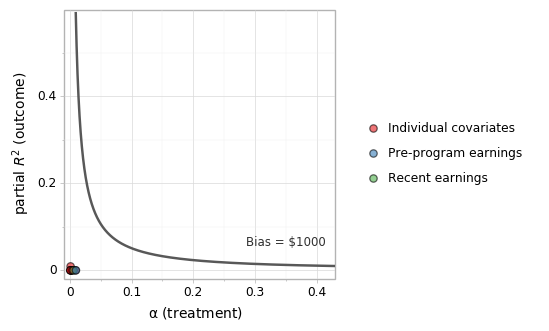

<ggplot: (171457917623)>

In [22]:
plot_sensitivity_graph(imbens1, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=True, do_SMOTE=False)

In [ ]:
# plot_sensitivity_graph(imbens1, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=False)

## Imbens2 results

6.445728758164087e-17
0.001
             g             Q
0     0.833080   4792.049137
1     0.947016   6639.524994
2     0.983132   5031.725868
3     0.955939   4669.331030
4     0.920640   2403.344910
...        ...           ...
2670  0.001000  34583.131991
2671  0.001000  55730.402729
2672  0.001000  44129.909267
2673  0.001000  39504.346577
2674  0.001000  48998.802281

[2675 rows x 2 columns]
                    covariates  alpha_hat   Rsq_hat                 groups
0                        [age]   0.001050  0.005640  individual_covariates
1                  [education]   0.000000  0.015901  individual_covariates
2                      [black]   0.146515  0.000000  individual_covariates
3                   [hispanic]   0.042009  0.000322  individual_covariates
4                    [married]   0.051604  0.000352  individual_covariates
5                       [RE74]   0.000000  0.033813  individual_covariates
6                       [RE75]   0.100020  0.102387  individual_covariates

C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 5699 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


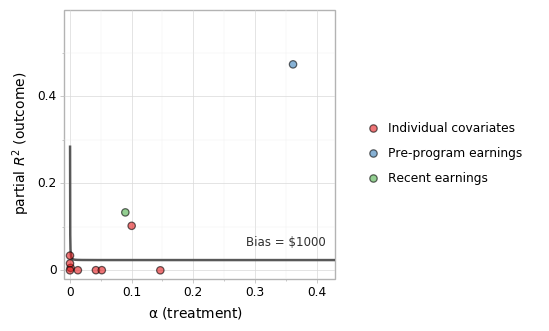

<ggplot: (171459346289)>

In [36]:
#kfold truw, smote false
plot_sensitivity_graph(imbens2, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=True, do_SMOTE=False)

                 g             Q
0     8.657587e-01   4792.049137
1     8.312281e-01   6639.524994
2     9.161643e-01   5031.725868
3     9.062472e-01   4669.331030
4     7.909720e-01   2403.344910
...            ...           ...
2670  6.120674e-06  34583.131991
2671  1.521744e-09  55730.402729
2672  6.520694e-07  44129.909267
2673  9.684844e-08  39504.346577
2674  2.227000e-08  48998.802281

[2675 rows x 2 columns]
                    covariates  alpha_hat   Rsq_hat                 groups
0                        [age]   0.000000  0.005640  individual_covariates
1                  [education]   0.084028  0.015901  individual_covariates
2                      [black]   0.000000  0.000000  individual_covariates
3                   [hispanic]   0.000000  0.000322  individual_covariates
4                    [married]   0.000000  0.000352  individual_covariates
5                       [RE74]   0.001284  0.033813  individual_covariates
6                       [RE75]   0.238185  0.102387  i

C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 5700 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


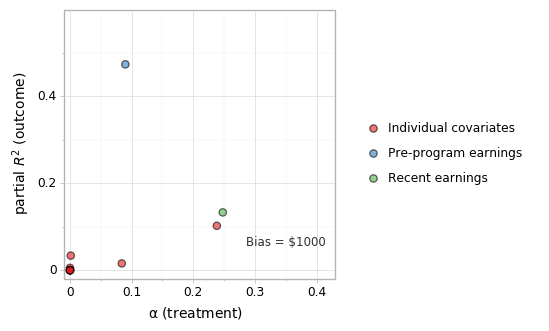

<ggplot: (171459155818)>

In [32]:
#kfold true, smote true
plot_sensitivity_graph(imbens2, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=True, do_SMOTE=True)

In [24]:
#plot_sensitivity_graph(imbens2, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=False)

## Imbens 3 results

                 g             Q
0     8.330801e-01   4792.049137
1     9.470159e-01   6639.524994
2     9.831321e-01   5031.725868
3     9.559389e-01   4669.331030
4     9.206395e-01   2403.344910
...            ...           ...
2670  4.792584e-05 -10084.233009
2671  1.745502e-10   8707.999729
2672  1.524785e-06  -4068.053733
2673  8.715976e-07  -9724.191423
2674  8.467024e-07  -1942.134719

[2675 rows x 2 columns]
                    covariates  alpha_hat   Rsq_hat                 groups
0                        [age]   0.004385  0.005640  individual_covariates
1                  [education]   0.002999  0.015901  individual_covariates
2                      [black]   0.149365  0.000000  individual_covariates
3                   [hispanic]   0.045207  0.000322  individual_covariates
4                    [married]   0.054771  0.000352  individual_covariates
5                       [RE74]   0.000000  0.149654  individual_covariates
6                       [RE75]   0.103025  0.102387  i

C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 5700 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


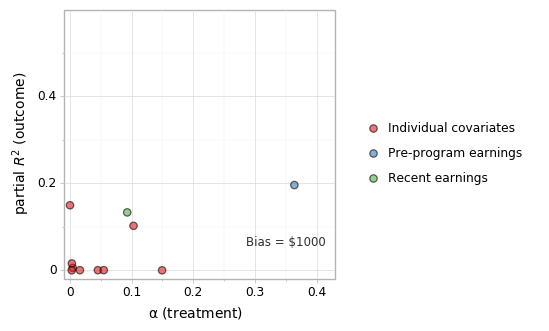

<ggplot: (-9223371874981230781)>

In [25]:
plot_sensitivity_graph(imbens3, treatment_col='treatment', response_col='change_earnings', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=True)

In [26]:
#plot_sensitivity_graph(imbens3, treatment_col='treatment', response_col='change_earnings', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=False)

## Imbens4 results

            g            Q
0    0.492476  5778.599533
1    0.755194  6322.613308
2    0.911010  5956.307679
3    0.924552  6144.018300
4    0.885467  4454.383724
..        ...          ...
385  0.001429  5541.566189
386  0.047935  7333.172847
387  0.517426  7085.936857
388  0.057505  6988.532239
389  0.015353  4683.070218

[390 rows x 2 columns]
0       349883.971300
1       174924.489702
2       116604.662502
3        87444.748903
4        69948.800743
            ...      
9994         0.017505
9995         0.014002
9996         0.010501
9997         0.007000
9998         0.003500
Length: 9999, dtype: float64
0.0028900474236491273
0.005846962495366696
0.008874266598844513
0.011975371210592825
0.015153537146865726
0.018411847636201906
0.0217531938594946
0.02518027038951028
0.028695577792133383
0.032301430002797504
0.03599996460868883
0.03979315466950266
0.04368282112721571
0.04767064517550622
0.05175818019270813
0.05594686300607395
0.06023802436689602
0.0646328985901137
0.069132632359

17.85939722416223
17.93324411792226
18.007259987411512
18.08144493709642
18.15579907149895
18.230322495196656
18.305015312822867
18.379877629066623
18.454909548672948
18.53011117644274
18.605482617233037
18.681023975956975
18.75673535758395
18.832616867139656
18.90866860970622
18.984890690422247
19.06128321448291
19.137846287140064
19.2145800137023
19.29148449953504
19.368559850060645
19.445806170758452
19.52322356716489
19.600812144873576
19.678572009535355
19.75650326685843
19.834606022608416
19.912880382608417
19.991326452739173
20.069944338939024
20.14873414720412
20.22769598358839
20.30682995420374
20.38613616522002
20.46561472286518
20.545265733425328
20.625089303244813
20.70508553872631
20.78525454633087
20.865596432578062
20.946111304045992
21.02679926737143
21.107660429249844
21.18869489643551
21.26990277574161
21.351284174040245
21.432839198262577
21.514567955398906
21.596470552498694
21.678547096670705
21.760797695083028
21.843222454963218
21.92582148359831
22.00859488833494

81.15542140544603
81.33205213501533
81.50891491171308
81.68600987810487
81.86333717684717
82.04089695068757
82.2186893424648
82.39671449510868
82.57497255164043
82.7534636551725
82.93218794890886
83.11114557614488
83.29033668026742
83.46976140475509
83.64941989317813
83.82931228919857
84.00943873657022
84.18979937913882
84.37039436084207
84.5512238257098
84.73228791786387
84.91358678151826
85.09512056097941
85.27688940064596
85.45889344500887
85.6411328386518
85.82360772625078
86.00631825257442
86.18926456248424
86.37244680093427
86.55586511297152
86.73951964373586
86.92341053846008
87.1075379424701
87.29190200118492
87.47650286011677
87.66134066487109
87.84641556114657
88.03172769473551
88.21727721152352
88.40306425748982
88.58908897870721
88.77535152134222
88.96185203165514
89.14859065600015
89.33556754082522
89.52278283267235
89.71023667817758
89.8979292240712
90.08586061717752
90.27403100441524
90.46244053279727
90.65108934943113
90.83997760151863
91.02910543635629
91.2184730013352

212.1052887257075
212.42834885386637
212.75173186110788
213.0754379498776
213.3994673227576
213.7238201824671
214.04849673186257
214.37349717393795
214.69882171182417
215.0244705487902
215.35044388824235
215.67674193372443
216.00336488891875
216.33031295764488
216.657586343861
216.9851852516627
217.31310988528475
217.64136044909978
217.96993714761894
218.29884018549205
218.62806976750744
218.95762609859264
219.28750938381373
219.6177198283759
219.94825763762375
220.27912301704046
220.61031617224936
220.94183730901278
221.27368663323233
221.60586435095024
221.93837066834732
222.27120579174527
222.60436992760538
222.93786328252895
223.2716860632576
223.60583847667328
223.94032072979832
224.27513302979597
224.61027558396947
224.94574859976336
225.28155228476274
225.61768684669389
225.95415249342417
226.29094943296184
226.6280778734571
226.96553802320076
227.30333009062596
227.64145428430692
227.97991081295973
228.31869988544264
228.65782171075546
228.99727649804046
229.3370644565818
229.6

396.3562643103772
396.84991454267174
397.3439960284399
397.8385090452442
398.33345387084296
398.82883078319145
399.32464006044194
399.82088198094374
400.31755682324365
400.81466486608565
401.3122063884113
401.81018166936025
402.30859098826954
402.80743462467456
403.3067128583092
403.80642596910485
404.30657423719265
404.80715794290137
405.30817736675954
405.80963278949383
406.31152449203097
406.81385275549627
407.31661786121543
407.8198200907128
408.32345972571363
408.8275370481421
409.3320523401234
409.83700588398295
410.3423979622462
410.8482288576395
411.35449885309043
411.8612082317265
412.368357276878
412.8759462720746
413.3839755010491
413.8924452477349
414.40135579626747
414.91070743098464
415.42050043642604
415.9307350973333
416.4414116986511
416.95253052552647
417.4640918633092
417.9760959975519
418.4885432140109
419.00143379864494
419.51476803761653
420.0285462172925
420.54276862424257
421.05743554524065
421.5725472672649
422.08810407749775
422.60410626332634
423.120554112341

726.7593129591113
727.5264727287678
728.2942433012424
729.0626250851524
729.8316184894195
730.601223923275
731.3714417962544
732.1422725182022
732.913716499269
733.6857741499139
734.458445880904
735.2317321033139
736.005633228528
736.7801496682386
737.5552818344464
738.3310301394625
739.1073949959074
739.8843768167116
740.6619760151151
741.4401930046681
742.2190281992324
742.9984820129799
743.7785548603946
744.5592471562712
745.340559315716
746.122491754147
746.9050448872958
747.6882191312056
748.4720149022331
749.2564326170465
750.0414726926284
750.8271355462753
751.6134215955975
752.4003312585186
753.1878649532779
753.976023098428
754.7648061128375
755.5542144156897
756.3442484264847
757.1349085650353
757.9261952514738
758.718108906247
759.510649950119
760.3038188041699
761.0976158897985
761.8920416287194
762.6870964429653
763.4827807548872
764.279094987155
765.0760395627565
765.873614904997
766.6718214375032
767.47065958422
768.2701297694113
769.0702324176629
769.8709679538781
770.6

1165.655982991436
1166.7636337257652
1167.8721279630436
1168.9814662914985
1170.0916492998235
1171.2026775771776
1172.3145517131882
1173.4272722979495
1174.540839922023
1175.6552551764396
1176.7705186526982
1177.8866309427656
1179.0035926390801
1180.1214043345499
1181.2400666225526
1182.3595800969363
1183.479945352021
1184.6011629825991
1185.7232335839342
1186.8461577517628
1187.9699360822933
1189.094569172209
1190.2200576186679
1191.3464020192985
1192.4736029722087
1193.6016610759775
1194.7305769296622
1195.8603511327954
1196.9909842853851
1198.1224769879188
1199.2548298413576
1200.388043447144
1201.5221184071959
1202.657055323912
1203.7928548001696
1204.9295174393237
1206.0670438452119
1207.2054346221498
1208.3446903749366
1209.4848117088509
1210.6257992296528
1211.7676535435855
1212.9103752573747
1214.0539649782293
1215.1984233138412
1216.3437508723862
1217.4899482625246
1218.6370160934027
1219.7849549746504
1220.9337655163847
1222.083448329208
1223.2340040242093
1224.385433212965
1

1818.9378374313753
1820.5370943381986
1822.1375465687338
1823.7391949993096
1825.3420405069905
1826.94608396958
1828.5513262656264
1830.1577682744135
1831.765410875973
1833.374254951074
1834.984301381233
1836.5955510487097
1838.2080048365053
1839.821663628373
1841.4365283088057
1843.0525997630502
1844.6698788770934
1846.288366537677
1847.9080636322901
1849.52897104917
1851.1510896773084
1852.7744204064434
1854.3989641270698
1856.0247217304343
1857.6516941085347
1859.2798821541298
1860.9092867607242
1862.539908822586
1864.171749234735
1865.8048088929536
1867.4390886937786
1869.0745895345042
1870.7113123131892
1872.3492579286487
1873.9884272804609
1875.6288212689662
1877.2704407952658
1878.9132867612243
1880.557360069473
1882.2026616234048
1883.849192327181
1885.4969530857263
1887.1459448047365
1888.7961683906717
1890.4476247507628
1892.1003147930096
1893.7542394261804
1895.4093995598157
1897.0657961042284
1898.723429970504
1900.3823020704992
1902.0424133168456
1903.7037646229496
1905.36

2714.49107438404
2716.7596413776005
2719.029908651891
2721.3018775241326
2723.575549312737
2725.8509253373018
2728.12800691861
2730.406795378641
2732.6872920405626
2734.9694982287338
2737.253415268709
2739.5390444872364
2741.8263872122625
2744.115444772928
2746.4062184995782
2748.6987097237534
2750.9929197781944
2753.2888499968494
2755.5865017148676
2757.8858762686045
2760.1869749956227
2762.489799234686
2764.7943503257757
2767.10062961008
2769.4086384299962
2771.718378129139
2774.029850052333
2776.34305554562
2778.6579959562587
2780.9746726327253
2783.293086924716
2785.6132401831424
2787.9351337601443
2790.2587690090813
2792.5841472845395
2794.9112699423285
2797.2401383394836
2799.5707538342695
2801.903117786185
2804.23723155595
2806.573096505525
2808.910713998101
2811.250085398101
2813.591212071187
2815.9340953842575
2818.2787367054525
2820.625137404145
2822.9732988509527
2825.323222417736
2827.6749094776037
2830.028361404901
2832.383579575225
2834.740565365417
2837.0993201535725
283

4068.4591385161552
4071.7526636228
4075.0487111358198
4078.347283143521
4081.6483817362378
4084.952009006336
4088.258167048218
4091.566857958314
4094.878083835108
4098.191846779112
4101.508148892892
4104.82699228105
4108.148379050245
4111.4723113091795
4114.798791168617
4118.127820741366
4121.459402142306
4124.793537488365
4128.130228898536
4131.46947849388
4134.811288397521
4138.15566073466
4141.502597632559
4144.852101220557
4148.204173630078
4151.558816994618
4154.916033449752
4158.275825133142
4161.638194184534
4165.003142745767
4168.370672960761
4171.740786975548
4175.11348693823
4178.488774999025
4181.866653310245
4185.247124026305
4188.63018930373
4192.015851301147
4195.404112179287
4198.794974101006
4202.1884392312695
4205.584509737161
4208.983187787872
4212.384475554738
4215.788375211203
4219.194888932836
4222.604018897352
4226.0157672845735
4229.430136276479
4232.847128057172
4236.266744812896
4239.688988732041
4243.113862005134
4246.541366824849
4249.971505386019
4253.404279

6167.1683919117495
6172.102782730875
6177.041113048802
6181.983386398846
6186.929606318103
6191.879776347417
6196.8339000313945
6201.791980918428
6206.754022560656
6211.72002851402
6216.690002338231
6221.663947596794
6226.64186785701
6231.6237666899615
6236.609647670553
6241.599514377483
6246.5933703932615
6251.591219304228
6256.593064700528
6261.5989101761415
6266.608759328872
6271.622615760374
6276.640483076122
6281.662364885441
6286.688264801521
6291.718186441385
6296.7521334259345
6301.790109379924
6306.832117931977
6311.878162714604
6316.928247364168
6321.982375520945
6327.040550829079
6332.102776936621
6337.169057495513
6342.239396161598
6347.313796594632
6352.392262458286
6357.4747974201455
6362.561405151722
6367.652089328438
6372.746853629674
6377.845701738734
6382.948637342863
6388.055664133262
6393.166785805079
6398.2820060574195
6403.4013285933515
6408.524757119911
6413.652295348108
6418.7839469929295
6423.919715773337
6429.059605412288
6434.203619636728
6439.351762177609
64

9589.666473642854
9597.425467622885
9605.191071019019
9612.963290372218
9620.742132231167
9628.527603152339
9636.319709699936
9644.118458445946
9651.92385597013
9659.735908860046
9667.554623711036
9675.380007126287
9683.212065716778
9691.050806101362
9698.896234906679
9706.748358767272
9714.607184325549
9722.472718231786
9730.344967144136
9738.223937728684
9746.109636659401
9754.002070618188
9761.901246294894
9769.807170387294
9777.719849601113
9785.63929065007
9793.565500255834
9801.498485148099
9809.438252064514
9817.384807750781
9825.338158960602
9833.29831245572
9841.265275005917
9849.239053389045
9857.219654391018
9865.207084805816
9873.201351435533
9881.20246109034
9889.210420588548
9897.225236756569
9905.24691642897
9913.275466448453
9921.310893665877
9929.353204940284
9937.402407138901
9945.45850713712
9953.521511818553
9961.591428075051
9969.668262806657
9977.75202292167
9985.84271533665
9993.940346976406
10002.044924774018
10010.156455670867
10018.274946616624
10026.400404569

15044.470293912946
15057.091020722353
15069.72347454023
15082.36766838228
15095.023615281645
15107.69132828884
15120.370820471888
15133.062104916264
15145.765194724987
15158.480103018579
15171.206842935153
15183.9454276304
15196.695870277648
15209.458184067875
15222.23238220973
15235.018477929572
15247.8164844715
15260.62641509737
15273.448283086827
15286.28210173733
15299.127884364223
15311.985644300661
15324.855394897751
15337.737149524512
15350.63092156793
15363.53672443299
15376.454571542672
15389.384476338017
15402.326452278141
15415.280512840267
15428.246671519732
15441.224941830045
15454.215337302916
15467.21787148824
15480.2325579542
15493.259410287232
15506.298442092091
15519.349666991853
15532.413098627967
15545.488750660264
15558.576636767024
15571.676770644941
15584.789166009215
15597.913836593558
15611.050796150206
15624.200058449976
15637.3616372823
15650.535546455189
15663.721799795356
15676.920411148201
15690.131394377846
15703.354763367106
15716.59053201763
15729.83871

25695.82658903652
25719.04485687221
25742.28765759209
25765.555022975557
25788.8469848519
25812.163575100585
25835.504825651125
25858.870768483393
25882.261435627483
25905.67685916408
25929.117071224337
25952.582103990015
25976.07198969365
25999.586760618567
26023.12644909907
26046.69108752036
26070.280708318867
26093.895343982138
26117.535027049067
26141.199790109906
26164.88966580641
26188.604686831965
26212.34488593158
26236.110295902065
26259.900949592105
26283.716879902342
26307.55811978557
26331.424702246673
26355.316660342756
26379.234027183444
26403.176835930662
26427.145119798995
26451.13891205569
26475.15824602068
26499.20315506682
26523.273672619936
26547.369832158827
26571.49166721556
26595.639211375357
26619.81249827682
26644.011561612053
26668.23643512669
26692.487152620015
26716.76374794512
26741.06625500886
26765.394707772142
26789.74914024993
26814.129586511335
26838.53608067967
26862.968656932702
26887.427349502675
26911.912192676387
26936.423220795263
26960.960468255

43325.55116613167
43368.94878756051
43412.39963934882
43455.903803122455
43499.46136066024
43543.07239389432
43586.736984910254
43630.45521594776
43674.227169400656
43718.05292781744
43761.93257390171
43805.86619051204
43849.853860662995
43893.895667525
43937.99169442481
43982.14202484596
44026.34674242896
44070.60593097174
44114.91967442999
44159.288056917576
44203.71116270676
44248.1890762285
44292.721882073114
44337.30966499039
44381.952509889954
44426.65050184164
44471.403726076074
44516.21226798457
44561.07621311992
44605.99564719665
44650.970656091224
44696.00132584255
44741.087742652264
44786.229992885244
44831.42816306974
44876.682339898056
44921.992610226494
44967.35906107622
45012.78177963326
45058.26085324897
45103.79636944045
45149.388415890986
45195.03708045019
45240.7424511346
45286.50461612797
45332.32366378172
45378.199682615115
45424.132761315974
45470.1229887406
45516.17045391463
45562.27524603312
45608.43745446111
45654.6571687337
45700.934478556774
45747.26947380733

70337.36451997279
70416.80255276388
70496.35455466728
70576.02073300972
70655.80129558098
70735.69645063492
70815.70640689066
70895.83137353435
70976.07156021957
71056.42717706927
71136.8984346769
71217.48554410714
71298.18871689806
71379.00816506158
71459.9441010849
71540.99673793229
71622.16628904552
71703.45296834619
71784.8569902357
71866.37856959774
71948.01792179892
72029.77526269016
72111.65080860825
72193.64477637675
72275.75738330765
72357.98884720234
72440.3393863534
72522.80921954529
72605.39856605622
72688.10764565907
72770.93667862313
72853.88588571521
72936.95548820069
73020.14570784538
73103.45676691676
73186.88888818483
73270.44229492419
73354.11721091489
73437.91386044382
73521.83246830657
73605.87325980801
73690.0364607644
73774.32229750446
73858.73099687052
73943.26278622041
74027.91789342837
74112.69654688674
74197.59897550759
74282.62540872309
74367.7760764884
74453.05120928204
74538.4510381074
74623.97579449487
74709.62571050231
74795.401018717
74881.30195225746
7

142135.8405128352
142333.98938320414
142532.50479808156
142731.38763047123
142930.638755942
143130.25905263805
143330.24940128735
143530.6106852119
143731.34379033445
143932.44960518976
144133.9290209335
144335.7829313507
144538.01223286492
144740.6178245488
144943.60060813217
145146.9614880116
145350.701371261
145554.82116763951
145759.3217896009
145964.20415230494
146169.46917362514
146375.1177741596
146581.15087724008
146787.56940894068
146994.3742980899
147201.5664762786
147409.14687786993
147617.11644001002
147825.47610263675
148034.22680849134
148243.36950312636
148452.9051349175
148662.8346550718
148873.1590176396
149083.87917952347
149294.99610048847
149506.51074317316
149718.42407309942
149930.73705868138
150143.45067123853
150356.56588500377
150570.08367713515
150784.00502772612
150998.33091981444
151213.0623393958
151428.20027543203
151643.74571986235
151859.6996676145
152076.0631166148
152292.83706779926
152510.02252512498
152727.6204955804
152945.631989196
153164.058019055

292953.61290391075
293479.88768776145
294007.4607562035
294536.3362787865
295066.5184416551
295598.01144762605
296130.81951626815
296664.94688398385
297200.3978040865
297737.176546882
298275.2873997533
298814.73466723645
299355.52267110674
299897.655750459
300441.1382617934
300985.97457909543
301532.16909392166
302079.72621548397
302628.6503707348
303178.9460044518
303730.6175793232
304283.66957603587
304838.10649335926
305393.93284823437
305951.15317586466
306509.772029797
307069.7939820159
307631.22362303437
308194.0655619757
308758.32442667073
309324.00486374856
309891.11153872404
310459.6491360884
311029.62235941
311601.03593141824
312173.89459409995
312748.20310879574
313323.96625629126
313901.18883691326
314479.87567062484
315060.0315971208
315641.6614759277
316224.7701864947
316809.36262829765
317395.4437209345
317983.01840422326
318572.0916383032
319162.66840373364
319754.75370159285
320348.35255358473
320943.47000213375
321540.111110493
322138.28096284025
322737.9846643888
323

1054298.6492321645
1057473.4582199259
1060661.9408167838
1063864.1746418406
1067080.2378629525
1070310.209201364
1073554.1679364326
1076812.193910331
1080084.3675328824
1083370.7697863602
1086671.4822303844
1089986.5870068772
1093316.1668450122
1096660.3050662738
1100019.085589515
1103392.5929361295
1106780.912235188
1110184.1292287305
1113602.3302770148
1117035.6023638714
1120484.0331021145
1123947.7107389814
1127426.724161639
1130921.1629027482
1134431.1171461092
1137956.67773227
1141497.93616435
1145054.9846137648
1148627.915926111
1152216.8236270573
1155821.8019283386
1159442.9457337742
1163080.350645364
1166734.112969465
1170404.3297229807
1174091.098639658
1177794.5181764592
1181514.687519957
1185251.706592816
1189005.6760603427
1192776.6973371245
1196564.8725936862
1200370.3047632463
1204193.097548581
1208033.355428889
1211891.183666751
1215766.6883152057
1219659.9762248462
1223571.1550510256
1227500.3332610936
1231447.620141786
1235413.1258066
1239396.9612033244
1243399.2381216

14217061.222739471
14359034.28840478
14503115.015324945
14649345.181169964
14797767.602426535
14948426.165528204
15101365.859078182
15256632.807208648
15414274.304125464
15574338.849883039
15736876.187443059
15901937.341066144
16069574.656095052
16239841.840185884
16412794.006046442
16588487.715749003
16766981.026679289
16948333.53919372
17132606.4460582
17319862.583744656
17510166.485662665
17703584.437415693
17900184.534163862
18100036.740192194
18303212.9507753
18509787.056445573
18719835.009768493
18933434.89473884
19150666.998917833
19371613.888430506
19596360.485960662
19824994.15187446
20057604.76862011
20294284.828557488
20535129.525371905
20780236.84924832
21029707.685975518
21283645.920174025
21542158.54283762
21805355.76340372
22073351.126565978
22346261.63406105
22624207.871673573
22907314.141718812
23195708.601269096
23489523.406413425
23788894.862857554
24093963.583175868
24404874.651054777
24721777.79290008
25044827.55715903
25374183.501787435
25710010.390261654
26052478

C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 5710 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


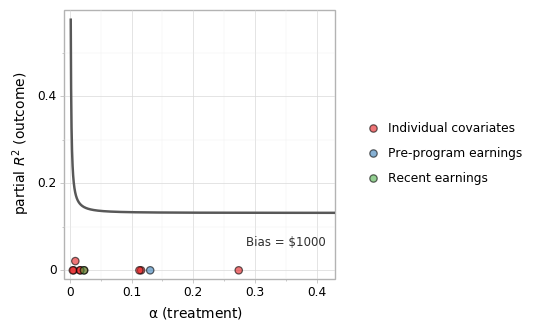

<ggplot: (161873551252)>

In [58]:
plot_sensitivity_graph(imbens4, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=True)

In [28]:
#plot_sensitivity_graph(imbens4, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=False)

In [29]:
#